In [2]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
import cloudpickle as cpl
from collections import defaultdict
import os
from joblib import Parallel, delayed

lmap = lambda func, *iterable: list(map(func, *iterable))

In [3]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

cmap = LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"])
mpl.colormaps.register(cmap)

In [4]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

#### Normalize by scale

In [ ]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][:].reshape(-1, 9) 

In [9]:
def scale(X):
    den = np.linalg.norm(X, np.inf, axis=1)
    den = np.where(den == 0, 1, den)[:, None]
    return X / den

dX = scale(dX)

In [52]:
def set_dataset(file, key, value, overwrite=True):
    if key not in file:
        file.create_dataset(key, data=value)
    elif overwrite:
        del file[key]
        file[key] = value
        
with h5py.File(dataset_path, "a") as f:
    set_dataset(f, "scaled_filters", dX)

#### Load scaled

In [5]:
with h5py.File(dataset_path, "r") as f:
    dX = f["scaled_filters"][:]

In [10]:
with h5py.File(dataset_path, "r") as f:
    sparse_ids = set(f["sparse_filter_ids"][:])

In [11]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: list(set(np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1]))) - sparse_ids))
df_meta.Robust = df_meta.Robust.apply(bool)

In [9]:
non_sparse_mask = np.ones(len(dX), bool)
non_sparse_mask[list(sparse_ids)] = 0

In [12]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)
all_used_model_names = pd.concat([df_pairings.Robust, df_pairings.Normal]).unique()

In [13]:
pca_dict = {}

In [9]:
if os.path.exists("pca_dict.cpkl"):    
    with open("pca_dict.cpkl", "rb") as f:
        pca_dict = cpl.load(f) 

In [14]:
for model in tqdm(all_used_model_names):
    ids = list(np.hstack(df_meta[df_meta.Name == model].filter_ids))
    pca_dict[model] = PCA(n_components=9).fit(dX[ids])

  0%|          | 0/114 [00:00<?, ?it/s]

In [15]:
ids = list(np.hstack(df_meta[df_meta.Name.isin(all_used_model_names)].filter_ids))
pca_dict["full"] = PCA(n_components=9).fit(dX[ids])

In [16]:
ids = list(np.hstack(df_meta[df_meta.Name.isin(df_pairings.Robust)].filter_ids))
pca_dict["robust"] = PCA(n_components=9).fit(dX[ids])

In [17]:
ids = list(np.hstack(df_meta[df_meta.Name.isin(df_pairings.Normal)].filter_ids))
pca_dict["normal"] = PCA(n_components=9).fit(dX[ids])

In [18]:
with open("pca_dict.cpkl", "wb") as f:
    cpl.dump(pca_dict, f) 

In [19]:
def plot_basis(pca):
    fig, axes = plt.subplots(1, 9, figsize=(9, 1))
    
    t = np.abs(pca.components_).max()
    
    for i, (ax, c, ratio) in enumerate(zip(axes, pca.components_.reshape(-1, 3, 3), pca.explained_variance_ratio_)):
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        im = ax.imshow(c, vmin=-t, vmax=t, cmap="CyanOrange")
        ax.set_title(f"$v_{i}$", fontweight='bold', fontsize=18)
        ax.set_xlabel(f"{ratio:.2f}", fontsize=18)

    cb_ax = fig.add_axes([0.8275, 0.15, 0.1, 0.7])    
    cb_ax.axis("off")
    cb = fig.colorbar(im, ax=cb_ax, aspect=10)
    cb.outline.set_visible(False)

In [20]:
def plot_cumsum_variance(pcas, labels):
    fig = plt.figure(figsize=([8, 5]))
    colors = cc.glasbey_category10
    
    for i, (pca, label) in enumerate(zip(pcas, labels)):
        plt.plot(range(1, 10), np.cumsum(pca.explained_variance_ratio_), label=label, color=colors[i])
    
    plt.ylabel("cumulative share of explained variance")
    plt.xlabel("principal components")
    plt.grid()
    plt.legend()

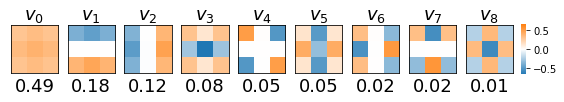

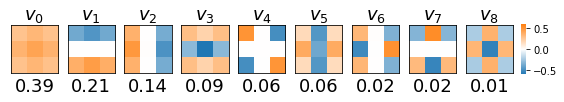

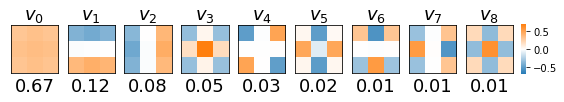

In [21]:
plot_basis(pca_dict["full"])
plt.savefig("plots/pca_basis_full.pdf", bbox_inches='tight')
plt.show()
plot_basis(pca_dict["robust"])
plt.savefig("plots/pca_basis_robust.pdf", bbox_inches='tight')
plt.show()
plot_basis(pca_dict["normal"])
plt.savefig("plots/pca_basis_normal.pdf", bbox_inches='tight')
plt.show()

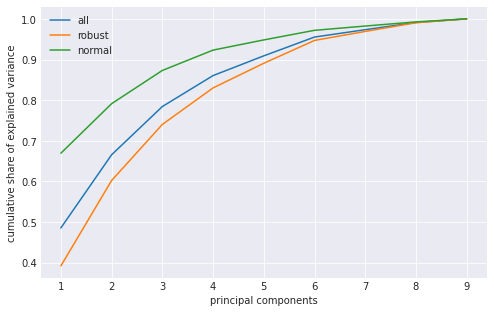

In [22]:
with plt.style.context("seaborn-dark"):
    plot_cumsum_variance([pca_dict["full"], pca_dict["robust"], pca_dict["normal"]], ["all", "robust", "normal"])
    plt.savefig("plots/pca_cumsum.pdf", bbox_inches='tight')

## Entropy

In [23]:
def entropy_cond(w):
    import scipy.stats

    u, s, v_h = np.linalg.svd(w - w.mean(axis=0), full_matrices=False, compute_uv=True)
    v = s**2 / (w.shape[0]-1)
    return scipy.stats.entropy(v, base=10)

In [24]:
entropy = Parallel(n_jobs=-1, verbose=100)(delayed(entropy_cond)(dX[ids]) for ids in tqdm(zip(df_meta.reset_index().filter_ids)))

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

In [78]:
np.save("entropy.npy", np.array(entropy))

In [25]:
df_meta["entropy"] = entropy

In [87]:
def set_box_color(bp, color):
    for patch in bp["boxes"]:
        patch.set(facecolor=color)

    plt.setp(bp["medians"], color="black")
    plt.setp(bp["means"], color="black")
    
def boxplots(selectors, labels=None, ax=None):
    
    if ax is None:
        plt.figure(facecolor="white")
        ax = plt.gca()
        
    n = len(selectors)
    w = 1 / n
    p = 0.2
    
    for i, selector in enumerate(selectors):
    
        df = selector
            
        bp = ax.boxplot(df.values, positions=np.array(range(len(df.values)))*n-(w/2)+(w+p)*i-p*n, widths=w, showmeans=True, patch_artist=True, meanprops={"markerfacecolor": "black", "markeredgecolor":"black", "markersize":4}, flierprops = dict(marker='.', markersize=4))
        color = f"C{i%9}"
        set_box_color(bp, color)
        if labels:
            ax.plot([], c=color, linewidth=5, label=labels[i])

#     ax.legend()
    ax.set_xticks(range(0, len(df.index)*n, n), df.index, rotation=22.5)
    ax.set_xlabel("convolution depth decile")
    ax.grid(axis="y")

In [199]:
df = df_meta.reset_index()
df.groupby(pd.cut(df.conv_depth_norm, np.linspace(0, 1, 11))).conv_depth.max()

conv_depth_norm
(0.0, 0.1]     10
(0.1, 0.2]     21
(0.2, 0.3]     31
(0.3, 0.4]     42
(0.4, 0.5]     52
(0.5, 0.6]     63
(0.6, 0.7]     73
(0.7, 0.8]     84
(0.8, 0.9]     94
(0.9, 1.0]    105
Name: conv_depth, dtype: int64

In [204]:
def agg_by_depth_decile(parent):
    agg = []
    for i, index in enumerate(parent.apply(lambda name: df_meta[df_meta.model == name].index)):
        df = df_meta.loc[index]
        df = df.reset_index()
        df.model_id = i
        df = df.set_index(["model_id", "conv_depth", "conv_depth_norm", "layer_id"])
        agg.append(df)
    selector = pd.concat(agg)
    
    grouper = lambda s: s.apply(lambda s: pd.Series({"result": (s["entropy"] * s["filter_ids"].apply(len)).sum() / (s["filter_ids"].apply(len)).sum()}))\
                        .groupby(level=0).result.apply(np.hstack)
    
    first = selector[selector.index.get_level_values("conv_depth") == 0]
    
    stack = []
    
    if len(first) > 0:
        stack.append(grouper(first.groupby(["conv_depth", "model_id"])))
    
    stack.append(grouper(selector.groupby([pd.cut(selector.index.get_level_values(2), np.linspace(0, 1, 11)), "model_id"])))
    
    return pd.concat(stack)

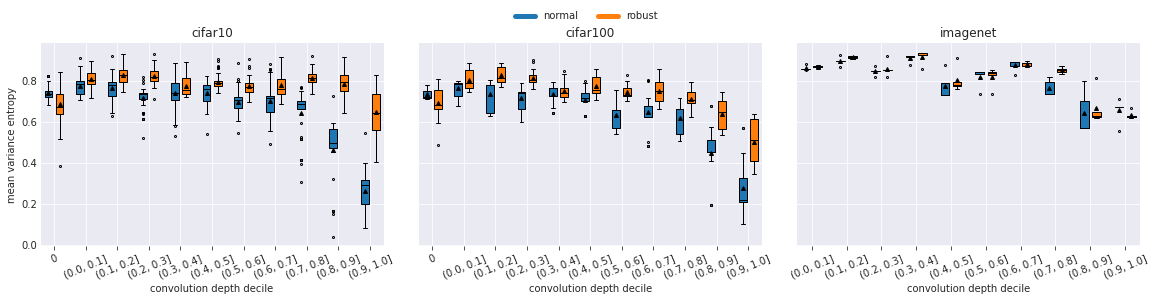

In [206]:
from boxplots import boxplots

with plt.style.context("seaborn-dark"):
    plt.rcParams['xtick.major.size'] = 3.5
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), facecolor="white", sharey=True)

    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar10_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar10_")].Robust),
        ], labels=["normal", "robust"], ax=axes[0])
    axes[0].set_title("cifar10")

    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar100_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar100_")].Robust),
        ], labels=["normal", "robust"], ax=axes[1])
    axes[1].set_title("cifar100")


    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_imagenet1k_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_imagenet_")].Robust),
        ], labels=["normal", "robust"], ax=axes[2])
    axes[2].set_title("imagenet")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0, 0.05, 1, 1), ncol=3)
    fig.tight_layout()
    axes[0].set_ylabel("mean variance entropy")
    plt.savefig("plots/entropy_normal_vs_robust.pdf", bbox_inches='tight')

## Coefficient

In [29]:
dX_trans = pca_dict["full"].transform(dX)

In [30]:
dX_trans_range = dX_trans.min(), dX_trans.max()

In [31]:
del dX

In [32]:
def ridge_plot(X, xrange, shape, row_labels=None, col_labels=None, figsize=(40, 10)):
    gs = grid_spec.GridSpec(*shape)
    fig = plt.figure(figsize=figsize)

    ax_objs = []
    for i in tqdm(range(shape[0])):
        for j in range(shape[1]):

            data = X[i][j]            
            dx, dy = FFTKDE(kernel="gaussian", bw='silverman').fit(data).evaluate()

            color = f"C{i%2}"
            
            # creating new axes object
            ax_objs.append(fig.add_subplot(gs[i:i+1, j:j+1]))

            # plotting the distribution
            ax_objs[-1].plot(dx, dy, color="#f0f0f0", lw=1)
            ax_objs[-1].fill_between(dx, dy, alpha=.7, color=color)

            # setting uniform x and y lims
            ax_objs[-1].set_xlim(*xrange)

            # make background transparent
            ax_objs[-1].patch.set_alpha(0)

            # remove borders, axis ticks, and labels
            ax_objs[-1].set_yticklabels([])
            ax_objs[-1].set_yticks([])
            ax_objs[-1].set_ylim([0, None])

            for s in ["top", "right", "left", "bottom"]:
                ax_objs[-1].spines[s].set_visible(False)
            
            if i == shape[0] - 1:
                ax_objs[-1].tick_params(direction="inout")
                ax_objs[-1].spines["bottom"].set_visible(True)
                
                if col_labels is not None:
                    ax_objs[-1].set_xlabel(col_labels[j])
            else:
                ax_objs[-1].set_xticks([])
                ax_objs[-1].set_xticklabels([])

            if j == 0 and row_labels is not None:
                ax_objs[-1].text(xrange[0] - 0.1, 0, row_labels[i], ha="right", wrap=True, color="black")

    gs.update(hspace=-0.5)

In [34]:
distributions_dataset_robustness = df_meta[df_meta.Name.isin(all_used_model_names)].groupby(["Training-Dataset", "Robust"]).filter_ids.apply(np.hstack) 

  0%|          | 0/6 [00:00<?, ?it/s]

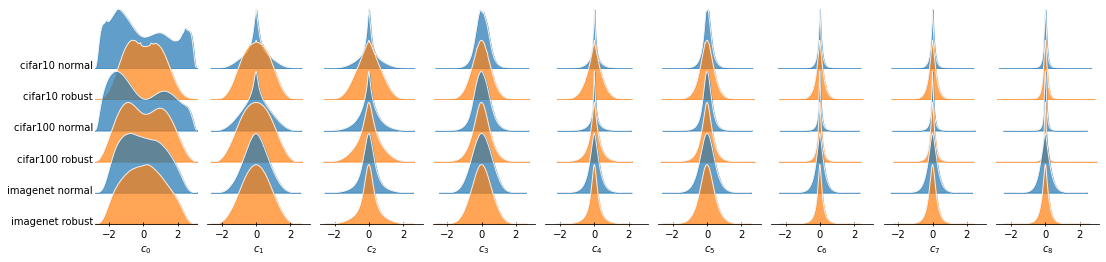

In [35]:
figsize=(18, 1 + 0.5 * len(distributions_dataset_robustness))
ridge_plot([dX_trans[v].T for v in distributions_dataset_robustness.values], xrange=dX_trans_range, 
           shape=(len(distributions_dataset_robustness), 9), 
           row_labels=[x[0] + " " + str(x[1]).replace("False", "normal").replace("True", "robust") for x in distributions_dataset_robustness.index], 
           col_labels=lmap(lambda i: f"$c_{i}$", range(9)), 
           figsize=figsize)
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.savefig("plots/ridge_dataset_by_robust.pdf", bbox_inches='tight')

In [36]:
def kl_sym(p, q):
    return scipy.stats.entropy(p, q) + scipy.stats.entropy(q, p)

def nd_kl_sym(p, q, weights=None):
    if type(p) is not list and len(p.shape) == 1:
        return kl_sym(p, q)
    else:
        return np.sum(lmap(lambda i: weights[i] * kl_sym(p[i], q[i]), range(len(p))))

def get_kl_matrix(data, bins, x_range, weights=None):
    d = len(data)
    kl_matrix = np.zeros((d, d))
    lookup = dict()
    for p, q in tqdm(itertools.product(range(d), repeat=2), total=d**2):
        if p not in lookup:
            lookup[p] = get_nd_discrete_probability_distribution(data[p], x_range, bins)
        if q not in lookup:
            lookup[q] = get_nd_discrete_probability_distribution(data[q], x_range, bins)
                
        kl_matrix[p, q] = nd_kl_sym(lookup[p], lookup[q], weights=weights)
    return kl_matrix

def get_discrete_probability_distribution(X, _range, bins):
    v, _ = np.histogram(X, range=_range, bins=bins, density=True)  # density will not sum to 1 but help to not underflow eps during normalization
    v = v.astype(np.double) 
    v[v == 0] = np.finfo(np.float32).eps
    v = v / np.sum(v)
    return v

def get_nd_discrete_probability_distribution(X, _range, bins):
    if type(X) is not list and len(X.shape) == 1:
        return get_discrete_probability_distribution(X, _range, bins)
    else:
        dims = list()
        for x in X:
            v = get_discrete_probability_distribution(x, _range, bins)
            dims.append(v)
        return np.vstack(dims)

def kl_plot(s, figsize=(10, 10), ax=None, sort=True, **kwargs):
    created = False
    if ax is None:
        created = True
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    img = get_kl_matrix(s.values, **kwargs)
    labels = s.index
    if sort:
        sort_index = np.argsort(np.mean(img, axis=0))
        img = img[sort_index][:, sort_index]
        labels = labels[sort_index]
    
    cim = ax.imshow(img, cmap=cc.cm["fire"])
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(len(s)))
    ax.set_yticklabels(labels, rotation=0)
    
    if created:
        plt.colorbar(cim)
    
    return ax, img

In [37]:
for dataset in df_pairings.Dataset.unique():
    df_pairs = df_pairings[df_pairings.Dataset == dataset].copy()
    robust_ids = np.hstack(df_meta.reset_index().set_index("model").loc[list(df_pairs.Robust.values)].filter_ids)
    normal_ids = np.hstack(df_meta.reset_index().set_index("model").loc[list(df_pairs.Normal.values)].filter_ids)

    robust_distr = get_nd_discrete_probability_distribution(dX_trans[robust_ids].T, _range=dX_trans_range, bins=70)
    normal_distr = get_nd_discrete_probability_distribution(dX_trans[normal_ids].T, _range=dX_trans_range, bins=70)
    
    kl = np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(x, y) for i, (x, y) in enumerate(zip(robust_distr, normal_distr))])
    
    print(dataset, kl)

cifar10 0.6216872648368879
cifar100 0.17417033901949838
imagenet 0.018076975926214274


In [66]:
dataset_depth_kl_dict = defaultdict(list)

for dataset in df_pairings.Dataset.unique():
    df_pairs = df_pairings[df_pairings.Dataset == dataset].copy()
    
    df = df_meta.reset_index().set_index("model").loc[list(df_pairs.Normal.values)]
    df = df[df.conv_depth > 0]
    normal_ids_by_depth = df.groupby(pd.cut(df["conv_depth_norm"], np.arange(0, 1.0+0.10, 0.10))).filter_ids.apply(np.hstack)
    
    df = df_meta.reset_index().set_index("model").loc[list(df_pairs.Robust.values)]
    df = df[df.conv_depth > 0]
    robust_ids_by_depth = df.groupby(pd.cut(df["conv_depth_norm"], np.arange(0, 1.0+0.10, 0.10))).filter_ids.apply(np.hstack)
    
    for normal_ids, robust_ids in tqdm(zip(normal_ids_by_depth, robust_ids_by_depth)):
        robust_distr = get_nd_discrete_probability_distribution(dX_trans[robust_ids].T, _range=dX_trans_range, bins=70)
        normal_distr = get_nd_discrete_probability_distribution(dX_trans[normal_ids].T, _range=dX_trans_range, bins=70)

        kl = np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(x, y) for i, (x, y) in enumerate(zip(robust_distr, normal_distr))])
        dataset_depth_kl_dict[dataset].append(kl)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [67]:
for dataset in df_pairings.Dataset.unique():
    df_pairs = df_pairings[df_pairings.Dataset == dataset].copy()
    
    kl = 0
    
    try: 
        df = df_meta.reset_index().set_index("model").loc[list(df_pairs.Robust.values)]
        robust_ids_by_depth = np.hstack(df[df.conv_depth==0].filter_ids)

        df = df_meta.reset_index().set_index("model").loc[list(df_pairs.Normal.values)]
        normal_ids_by_depth = np.hstack(df[df.conv_depth==0].filter_ids)

        robust_distr = get_nd_discrete_probability_distribution(dX_trans[robust_ids_by_depth].T, _range=dX_trans_range, bins=70)
        normal_distr = get_nd_discrete_probability_distribution(dX_trans[normal_ids_by_depth].T, _range=dX_trans_range, bins=70)

        kl = np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(x, y) for i, (x, y) in enumerate(zip(robust_distr, normal_distr))])
    except:
        pass
    
    dataset_depth_kl_dict[dataset] = [kl] + dataset_depth_kl_dict[dataset]

    print(dataset, kl)

cifar10 0.47239363591598216
cifar100 0.6257520844798422
imagenet 0


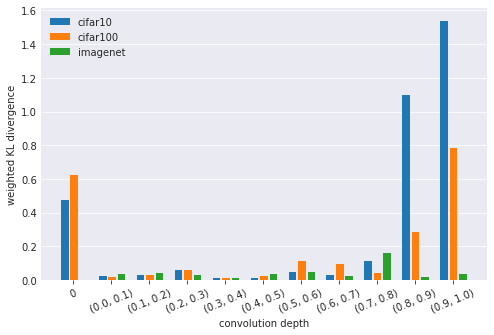

In [88]:
with plt.style.context("seaborn-dark"):
    plt.figure(figsize=([8, 5]))
    plt.rcParams['xtick.major.size'] = 3.5
    ind = np.arange(3)
    width = 0.2
    for i, (key, values) in enumerate(dataset_depth_kl_dict.items()):
        plt.bar(np.arange(len(values)) +  i * width + 0.05 * i, values, width, label=key, zorder=3)
    plt.legend()
    plt.ylabel("weighted KL divergence")
    plt.xlabel("convolution depth")
    plt.grid(zorder=0, axis="y")
    plt.xticks(np.arange(11) + (width + 0.025), [0] + [f"({x:0.1f}, {x+0.1:0.1f})" for x in np.arange(0, 1.0, 0.10)], rotation=22.5)
    plt.gca().xaxis.set_ticks_position("bottom")
    plt.savefig("plots/divergence_by_depth.pdf", bbox_inches='tight')

In [93]:
distributions_dataset_robustness = df_meta[df_meta.Name.isin(all_used_model_names)].groupby(["Training-Dataset", "Robust"]).filter_ids.apply(np.hstack).apply(lambda ids: get_nd_discrete_probability_distribution(dX_trans[ids].T, _range=dX_trans_range, bins=70))

In [94]:
np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(distributions_dataset_robustness[0][i], distributions_dataset_robustness[1][i]) for i in range(9)])

0.5532809635131727

In [95]:
np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(distributions_dataset_robustness[2][i], distributions_dataset_robustness[3][i]) for i in range(9)])

0.16284891793962583

In [96]:
np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(distributions_dataset_robustness[4][i], distributions_dataset_robustness[5][i]) for i in range(9)])

0.016085924022021813